# CMSC 320 Term Project

## Data Preprocessing

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats
import kagglehub
import os

In [21]:
path1 = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")
path1 = os.path.join(path1, "btcusd_1-min_data.csv")
path2 = kagglehub.dataset_download("odins0n/top-50-cryptocurrency-historical-prices")
path2 = os.path.join(path2, "All_combined.csv")

print("Path to dataset file for Bitcoin Historical Data:", path1)
print("Path to dataset files for Top 50 cryptos historical prices:", path2)

Path to dataset file for Bitcoin Historical Data: C:\Users\rayan\.cache\kagglehub\datasets\mczielinski\bitcoin-historical-data\versions\401\btcusd_1-min_data.csv
Path to dataset files for Top 50 cryptos historical prices: C:\Users\rayan\.cache\kagglehub\datasets\odins0n\top-50-cryptocurrency-historical-prices\versions\5\All_combined.csv


First, we read the csv files, then convert the Timestamp column into Pandas datetime objects, so that we can later use time based operations cleaner. Then we sort the Timestamp column chronologically so we are able to see trends clearer. Finally we drop any duplicated timestamps so that only the first occurence shows, which resolves any skew in the data.

In [22]:
btc = pd.read_csv(path1)

btc["Timestamp"] = pd.to_datetime(btc["Timestamp"], unit="s")
btc = btc.set_index("Timestamp").sort_index()
btc = btc[~btc.index.duplicated(keep="first")]

display(btc.head())

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [23]:
display(btc.tail())

,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-10-27 23:53:00,114129.0,114182.0,114129.0,114182.0,0.116283
2025-10-27 23:54:00,114186.0,114186.0,114171.0,114171.0,0.037052
2025-10-27 23:55:00,114187.0,114187.0,114187.0,114187.0,0.000045
2025-10-27 23:56:00,114189.0,114189.0,114119.0,114119.0,0.161391
2025-10-27 23:57:00,114105.0,114124.0,114105.0,114124.0,0.079630


Next, we run to see if there are missing values in the data. There appears to be none.

In [24]:
display(btc.isna().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Describe this dataset: Gives overview of each column of the dataframe.

In [25]:
display(btc[["Open", "High", "Low", "Close", "Volume"]].describe())

,Open,High,Low,Close,Volume
count,7.268797e+06,7.268797e+06,7.268797e+06,7.268797e+06,7.268797e+06
mean,2.073104e+04,2.073850e+04,2.072338e+04,2.073105e+04,5.149885e+00
std,2.933537e+04,2.934328e+04,2.932733e+04,2.933537e+04,2.213713e+01
min,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,4.403300e+02,4.405500e+02,4.400800e+02,4.403300e+02,1.904482e-02
50%,7.191870e+03,7.195650e+03,7.187920e+03,7.191760e+03,4.465496e-01
75%,3.022037e+04,3.022755e+04,3.021300e+04,3.022085e+04,2.910365e+00
max,1.262020e+05,1.262720e+05,1.261580e+05,1.262020e+05,5.853852e+03


## Weekday vs Weekend Volume T-Test
We test whether average trading activity differs between weekdays and weekends by comparing the log-transformed minute volumes with a Welch two-sample t-test and a simple boxplot.

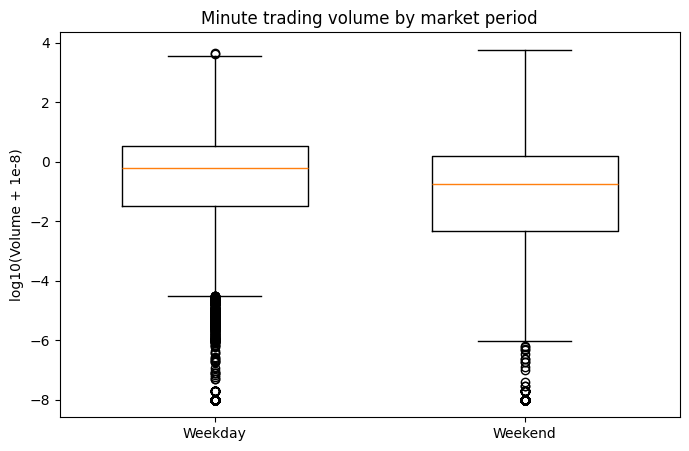

Weekday mean log volume:  -1.37866728249773 
Weekend mean log volume:  -2.0295251213328043 
T-value:  246.0820649448937 
P-Value:  0.0
1.5748195751115501 times more BTC per minute on weekdays.


In [26]:
weekday_mask = btc.index.dayofweek < 5
weekend_mask = ~weekday_mask

weekday_vol = np.log10(btc.loc[weekday_mask, "Volume"] + 1e-8)
weekend_vol = np.log10(btc.loc[weekend_mask, "Volume"] + 1e-8)

fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot([weekday_vol, weekend_vol], tick_labels=["Weekday", "Weekend"], widths=0.6)
ax.set_ylabel("log10(Volume + 1e-8)")
ax.set_title("Minute trading volume by market period")
plt.show()

t_stat, p_value = stats.ttest_ind(weekday_vol, weekend_vol, equal_var=False)
weekday_mean = weekday_vol.mean()
weekend_mean = weekend_vol.mean()
raw_ratio = btc.loc[weekday_mask, "Volume"].mean() / btc.loc[weekend_mask, "Volume"].mean()

print("Weekday mean log volume: ", weekday_mean,
      "\nWeekend mean log volume: ", weekend_mean,
      "\nT-value: ", t_stat,
      "\nP-Value: ", p_value) 
print(raw_ratio, "times more BTC per minute on weekdays.")

We compared minute bitcoin trading volumes between weekdays and weekends using a T-test on log10 because the raw minute volumes are very skewed. Weekdays show higher activity with mean log volume of -1.379 vs -2.030 which is around one and a half more raw volume per minute, with t=246 and p=0.0, so we reject the equal means. So we can conclude that the liquidity is higher on weekdays.

Next, moving to the second dataset, we make sure the 50 cryto-currency data is only relevant for the dates that we have data for Bitcoin. This is from 2012-01-01 and 2025-10-27.

In [27]:
t50 = pd.read_csv(path2, parse_dates=['Date'])
start = "2012-01-01" 
end = "2025-10-27"
mask = (t50['Date'] >= start) & (t50['Date'] <= end) 
t50 = t50.loc[mask] 
display(t50)

,Currency_Name,Date,Price,Open,High,Low,Vol.,Change %
0,Aave,2018-01-30,0.15000,0.17000,0.17000,0.14000,530470.0,-7.95
1,Aave,2018-01-31,0.14000,0.15000,0.15000,0.13000,396050.0,-11.10
2,Aave,2018-02-01,0.11000,0.14000,0.14000,0.11000,987260.0,-17.46
3,Aave,2018-02-02,0.10000,0.11000,0.11000,0.08000,1810000.0,-8.32
4,Aave,2018-02-03,0.11000,0.10000,0.12000,0.09000,1200000.0,6.85
...,...,...,...,...,...,...,...,...
53830,XPR,2015-01-26,0.01469,0.01700,0.01750,0.01469,0.0,-13.59
53831,XPR,2015-01-25,0.01700,0.01739,0.01739,0.01560,0.0,-2.24
53832,XPR,2015-01-24,0.01739,0.01600,0.01739,0.01500,0.0,8.69
53833,XPR,2015-01-23,0.01600,0.01602,0.01700,0.01600,0.0,-0.12


Check for null values

In [28]:
display(t50.isna().sum())

Currency_Name    0
Date             0
Price            0
Open             0
High             0
Low              0
Vol.             0
Change %         0
dtype: int64

No Null Values in dataset 2


Describing Dataset 2

In [29]:
display(t50.describe())

,Date,Price,Open,High,Low,Vol.,Change %
count,53303,53303.000000,53303.000000,53303.000000,53303.000000,5.330300e+04,53303.000000
mean,2019-07-08 16:55:45.042492928,786.885588,785.204735,812.773439,754.798277,3.715733e+09,1.517813
min,2012-01-01 00:00:00,0.000000,0.000000,0.000000,-6.503000,0.000000e+00,-100.000000
25%,2018-07-30 00:00:00,0.297300,0.297010,0.310245,0.281905,1.371350e+05,-2.370000
50%,2019-10-25 00:00:00,3.325700,3.319000,3.487100,3.112300,2.180000e+06,0.000000
75%,2020-11-02 00:00:00,67.405500,67.290000,69.815000,64.493500,4.149500e+07,2.640000
max,2021-08-24 00:00:00,63545.110000,63544.200000,64831.500000,62067.500000,8.574631e+12,42751.340000
std,NaN,4801.667173,4792.929378,4955.092001,4608.743419,8.824876e+10,189.242914


### Cumulative Return Analysis (2018-2021)

In [30]:
mask = (t50["Date"] >= "2018-01-01") & (t50["Date"] <= "2021-12-31")
filtered = t50.loc[mask].sort_values(["Currency_Name", "Date"]).copy()
filtered["Cumulative Return"] = (
    (1 + filtered["Change %"] / 100)
    .groupby(filtered["Currency_Name"])
    .cumprod() - 1
) * 100

fig = go.Figure()

for currency, subset in filtered.groupby("Currency_Name"):
    fig.add_trace(
        go.Scatter(
            x=subset["Date"],
            y=subset["Cumulative Return"],
            mode="lines",
            name=currency,
            line=dict(width=0.8),
            fill="tonexty",
            opacity=0.5
        )
    )

fig.add_hline(y=0, line=dict(color="black", width=1.5, dash="dot"))

fig.update_layout(
    title="Cumulative Growth of Major Cryptocurrencies (2018–2021)",
    title_x=0.5,
    xaxis_title="Date",
    yaxis_title="Total Return (%)",
    template="plotly_white",
    showlegend=True,
    margin=dict(l=60, r=40, t=90, b=60)
)

fig.update_xaxes(dtick="M6", tickformat="%b\n%Y", showgrid=True, gridcolor="lightgray")
fig.update_yaxes(ticksuffix="%", showgrid=True, gridcolor="lightgray", zeroline=True)

fig.show()


The filled cumulative return plot from 2018 to 2021 was chosen because it captures a complete market cycle in cryptocurrency history which includes the aftermath of the 2017 boom through the 2018 crash, 2020 pandemic shock, and the 2021 bull run thus, making it an ideal period to observe both downturns and recoveries. The visualization reveals that performance was highly uneven, with a few dominant coins such as Bitcoin and Ethereum showing strong, sustained growth while many others fluctuated near or below zero cumulative return. Moreover, I see that the wide spread and frequent crossings of the zero line highlight the market’s volatility and cyclical nature, where gains and losses occur in waves rather than stable trends. All in all, the time-series analysis indicates that long-term value creation in the crypto market was concentrated in a few leading assets, while most exhibited inconsistent growth, which underscored both the speculative and high-risk character of this market during the 2018–2021 period.


## Correlation Analysis Between Bitcoin and other Cryptocurrencies

We will analyze the correlation between daily return percentages to see how Bitcoin prices are correlated to some other popular cryptocurrencies.

In [31]:
import pandas as pd
import numpy as np
import plotly.express as px

btc = pd.read_csv(path1)

btc["DateTime"] = pd.to_datetime(btc["Timestamp"], unit="s")
btc = btc.sort_values("DateTime")

btc_daily = (
    btc.resample("1D", on="DateTime")
       .agg({"Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"})
       .dropna()
       .reset_index()
)
btc_daily.rename(columns={"DateTime": "Date"}, inplace=True)

t50 = pd.read_csv(path2)

t50["Date"] = pd.to_datetime(t50["Date"])
t50 = t50.sort_values("Date").reset_index(drop=True)

coin_name = "Ethereum"
coin = t50[t50["Currency_Name"] == coin_name].copy()

coin["Price"] = coin["Price"].replace(",", "", regex=True).astype(float)
btc_daily["Close"] = btc_daily["Close"].astype(float)

btc_daily["BTC_Return"] = btc_daily["Close"].pct_change() * 100
coin["Coin_Return"] = coin["Price"].pct_change() * 100

merged = pd.merge(
    btc_daily[["Date", "BTC_Return"]],
    coin[["Date", "Coin_Return"]],
    on="Date",
    how="inner"
).dropna().reset_index(drop=True)

correlation = merged["BTC_Return"].corr(merged["Coin_Return"])
print(f"Correlation between Bitcoin and {coin_name} daily returns: {correlation:.4f}")

fig = px.scatter(
    merged,
    x="BTC_Return",
    y="Coin_Return",
    trendline="ols",
    title=f"Correlation between Bitcoin and {coin_name} Daily Returns<br>r = {correlation:.4f}",
    labels={
        "BTC_Return": "Bitcoin Daily Return (%)",
        "Coin_Return": f"{coin_name} Daily Return (%)"
    }
)
fig.show()

merged["RollingCorr"] = merged["BTC_Return"].rolling(window=30).corr(merged["Coin_Return"])

fig2 = px.line(
    merged,
    x="Date",
    y="RollingCorr",
    title=f"30-Day Rolling Correlation between Bitcoin and {coin_name}",
    labels={"RollingCorr": "Rolling Correlation"}
)
fig2.show()


Correlation between Bitcoin and Ethereum daily returns: 0.4992


From the first plot above, we can see that Bitcoin and Ethereum have a moderately positive correlation of r = 0.4992 between their daily return percentages over the years that both coins have been active in the market. This means that changes in Bitcoin prices are not heavily correlated to those in Ethereum prices. This correlation could be due to a third factor like the economic health, which would cause similar rises and drops in most major cryptocurrencies. Also, by looking at the 30-day rolling correlation, we can see that at the start of the younger coin's activity, the correlation between their daily return percentages was changing drastically. This is likely due to the fact that newer cryptocurrencies are highly volatile and the newer coin at the time was seeing drastic price changes. However, as time passed and both coins stabilized in their volatility, we see the correlation between daily return percentage between Bitcoin and Ethereum stay mainly around r = 0.500 and r = 0.690.

In [36]:
import pandas as pd
import numpy as np
import plotly.express as px

btc = pd.read_csv(path1)

btc["DateTime"] = pd.to_datetime(btc["Timestamp"], unit="s")
btc = btc.sort_values("DateTime")

btc_daily = (
    btc.resample("1D", on="DateTime")
       .agg({"Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"})
       .dropna()
       .reset_index()
)
btc_daily.rename(columns={"DateTime": "Date"}, inplace=True)

t50 = pd.read_csv(path2)

t50["Date"] = pd.to_datetime(t50["Date"])
t50 = t50.sort_values("Date").reset_index(drop=True)

coin_name = "XPR"
coin = t50[t50["Currency_Name"] == coin_name].copy()

coin["Price"] = coin["Price"].replace(",", "", regex=True).astype(float)
btc_daily["Close"] = btc_daily["Close"].astype(float)

btc_daily["BTC_Return"] = btc_daily["Close"].pct_change() * 100
coin["Coin_Return"] = coin["Price"].pct_change() * 100

merged = pd.merge(
    btc_daily[["Date", "BTC_Return"]],
    coin[["Date", "Coin_Return"]],
    on="Date",
    how="inner"
).dropna().reset_index(drop=True)

correlation = merged["BTC_Return"].corr(merged["Coin_Return"])
print(f"Correlation between Bitcoin and {coin_name} daily returns: {correlation:.4f}")

fig = px.scatter(
    merged,
    x="BTC_Return",
    y="Coin_Return",
    trendline="ols",
    title=f"Correlation between Bitcoin and {coin_name} Daily Returns<br>r = {correlation:.4f}",
    labels={
        "BTC_Return": "Bitcoin Daily Return (%)",
        "Coin_Return": f"{coin_name} Daily Return (%)"
    }
)
fig.show()

merged["RollingCorr"] = merged["BTC_Return"].rolling(window=30).corr(merged["Coin_Return"])

fig2 = px.line(
    merged,
    x="Date",
    y="RollingCorr",
    title=f"30-Day Rolling Correlation between Bitcoin and {coin_name}",
    labels={"RollingCorr": "Rolling Correlation"}
)
fig2.show()


Correlation between Bitcoin and XPR daily returns: 0.1837


From the first plot above, we can see that Bitcoin and XPR have a weak positive correlation of r = 0.1837 between their daily return percentages over the years that both coins have been active in the market. This means that changes in Bitcoin prices are very lighly correlated to those in XPR prices. This could mean that economic factors affect the price changes in both of these coins very differently, leading to highly differing daily return percentages. Also, by looking at the 30-day rolling correlation, we can see that similar to the Bitcoin and Ethereum analysis, the correlation between their daily return percentages was changing drastically. This is also likely due to the fact that newer cryptocurrencies are highly volatile and the newer coin at the time was seeing drastic price changes. However, as time passed and both coins stabilized in their volatility, we see the correlation between daily return percentage between Bitcoin and XPR stay mainly positive around r = 0.400 with a dip into the r = 0.100 to r = 0.200 range at the start of 2021. This could have been due to the difference in how the COVID pandemic affected each coin's performance. However, there could be other factors as well. What is more relevant is that the correlation between the daily return percentages of the two cryptocurrencies has gone up to weakly-moderately positive since the start of 2018, potentially indicating a greater similarity in economic performace for Bitcoin and XPR.

From this, we can conclude that in our further analysis and machine learning section, we must account for the volatile nature of newer cryptocurrencies. We can see that as time passes, other major coins are more strongly correlated to Bitcoin daily return percentages. However, this is not the case for when the newer coin is still relatively young. Thus, we must account for how earlier data points may skew our correlations and other conclusions, as we can see that the earlier correlations clearly skew the overall correlation between Bitcoin and Ethereum, and Bitcoin and XPR daily return percentages.